In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os

sys.path.append("../../scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity
%aimport plotting

import glob
from tqdm import tqdm  # progress bar

In [ ]:
EC_AD = finder.Barcode(
    name="AD",
    preceder="GGCTAGC",
    post="",
    length=120
)

EC_AD_BC = finder.Barcode(
    name="AD_BC",
    preceder="CGCGCC",
    post="",
    length=11
)

EC_RPTR_BC = finder.Barcode(
    name="RPTR_BC",
    preceder="CTCGAG",
    post="",
    length=14
)

In [ ]:
print("Initializing map refiner...")

refiner = map_refiner.MapRefiner(
    db_path="/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_err_corr.db",
    bc_objects=[EC_AD, EC_AD_BC, EC_RPTR_BC],
    column_pairs=[("RPTR_BC", "AD")],
    design_check=True,
    reads_threshold=50,
    map_order=[
        "barcode_exists",
        "quality",
        "error_corrected",
        "grouped",
        "thresholded",
        "unique_target",
        "designed"
    ],
    step_name="step1",
    should_check_exists=False,
    plot_histograms=True,
    output_figures_path="../../output/GCN4_error_corrected/figures/"
)


In [ ]:
quality = refiner.get_map_df('quality')
quality

In [ ]:
quality_counts = quality.value_counts()
quality_counts

In [ ]:
sns.histplot(quality.value_counts())

In [8]:
refiner.get_map_df('error_corrected')

,AD,AD_qual,AD_BC,AD_BC_qual,RPTR_BC,RPTR_BC_qual,Designed
0,CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAA...,True,GCTAAGGCGTA,True,TGCAGGAGCCACTC,True,1
1,CCATTGATAATTCTAGAATTGCTGTTCCATCTCAAAGAAGACATTC...,True,TCCTGAGCTAC,True,CTAGGTTAAAAGTA,True,1
2,CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAA...,True,GCTAAGGCGTA,True,TGCAGGAGCCACTC,True,1
3,CCATTGATAATTCTAGAATTGCTGTTCCATCTCAAAGAAGACATTC...,True,TCCTGAGCTAC,True,CTAGGTTAAAAGTA,True,1
4,TTGGAAAGAAATGGTGCTAAGATTCAATTATAGAAGATGTTCTTTG...,True,CGCGGGAATAG,True,AGTTTTCGGGGATA,True,1
...,...,...,...,...,...,...,...
68343,AATAATTTGCCATCTGATTGGTTGTGTTCTGGTAATGGTGGTAATA...,True,AAGAGCCGGTA,True,GGGGTTAAGTTGAA,True,1
68344,CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAA...,True,GCTAAGGCGTA,True,TGCAGGAGCCACTC,True,1
68345,TTGGAAAGAAATGGTGCTAAGATTCAATTATAGAAGATGTTCTTTG...,True,CGCGGGAATAG,True,AGTTTTCGGGGATA,True,1
68346,TCTTCTCCAGCTGTTCCAACTGTCTTTGACTTTAATTCTGCTTCTT...,True,GGATACCCGGA,True,TTGTAAGTATTTTG,True,1


In [7]:
refiner.get_map_df('error_corrected').drop_duplicates()

,AD,AD_qual,AD_BC,AD_BC_qual,RPTR_BC,RPTR_BC_qual,Designed
0,CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAA...,True,GCTAAGGCGTA,True,TGCAGGAGCCACTC,True,1
1,CCATTGATAATTCTAGAATTGCTGTTCCATCTCAAAGAAGACATTC...,True,TCCTGAGCTAC,True,CTAGGTTAAAAGTA,True,1
4,TTGGAAAGAAATGGTGCTAAGATTCAATTATAGAAGATGTTCTTTG...,True,CGCGGGAATAG,True,AGTTTTCGGGGATA,True,1
5,GTTTCTCCATTTATTGGTGATAATCAAGATTTGGATCAAGCTTTGT...,True,TTGCCCATCGT,True,ATTTTGTATAACGG,True,1
6,TCTTCTCCAGCTGTTCCAACTGTCTTTGACTTTAATTCTGCTTCTT...,True,GGATACCCGGA,True,TTGTAAGTATTTTG,True,1
10,AATAATTTGCCATCTGATTGGTTGTGTTCTGGTAATGGTGGTAATA...,True,AAGAGCCGGTA,True,GGGGTTAAGTTGAA,True,1
11,AAACAAATTCATGTTGAACCAGAATTGGGTTCTGCTTTGCCAATGG...,True,ATGTTGATTAT,True,GCTTGGAAGATGGC,True,1
14,GATCAAGCTTTGTCTGGTGATCCATGGTATCCATTGTTTCCACAAG...,True,TGTACCTACAT,True,GCAACTAACCATTT,True,1


In [11]:
refiner.get_map_df('grouped')

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed
0,CCATTGATAATTCTAGAATTGCTGTTCCATCTCAAAGAAGACATTC...,TCCTGAGCTAC,CTAGGTTAAAAGTA,16035,True,True,True,1
1,CAACAAACTCAACCATTGCCAGAATTGGTTCAACCAGTTCAACCAA...,GCTAAGGCGTA,TGCAGGAGCCACTC,11055,True,True,True,1
2,GTTTCTCCATTTATTGGTGATAATCAAGATTTGGATCAAGCTTTGT...,TTGCCCATCGT,ATTTTGTATAACGG,10268,True,True,True,1
3,TTGGAAAGAAATGGTGCTAAGATTCAATTATAGAAGATGTTCTTTG...,CGCGGGAATAG,AGTTTTCGGGGATA,8612,True,True,True,1
4,AATAATTTGCCATCTGATTGGTTGTGTTCTGGTAATGGTGGTAATA...,AAGAGCCGGTA,GGGGTTAAGTTGAA,6470,True,True,True,1
5,AAACAAATTCATGTTGAACCAGAATTGGGTTCTGCTTTGCCAATGG...,ATGTTGATTAT,GCTTGGAAGATGGC,5477,True,True,True,1
6,GATCAAGCTTTGTCTGGTGATCCATGGTATCCATTGTTTCCACAAG...,TGTACCTACAT,GCAACTAACCATTT,5381,True,True,True,1
7,TCTTCTCCAGCTGTTCCAACTGTCTTTGACTTTAATTCTGCTTCTT...,GGATACCCGGA,TTGTAAGTATTTTG,5050,True,True,True,1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Saved loss summary table as 'step1_AD_AD_BC_RPTR_BC_loss_summary'
Done in 3.85 seconds.



<Axes: xlabel='Read Count (Unique, Total)', ylabel='Map Step'>

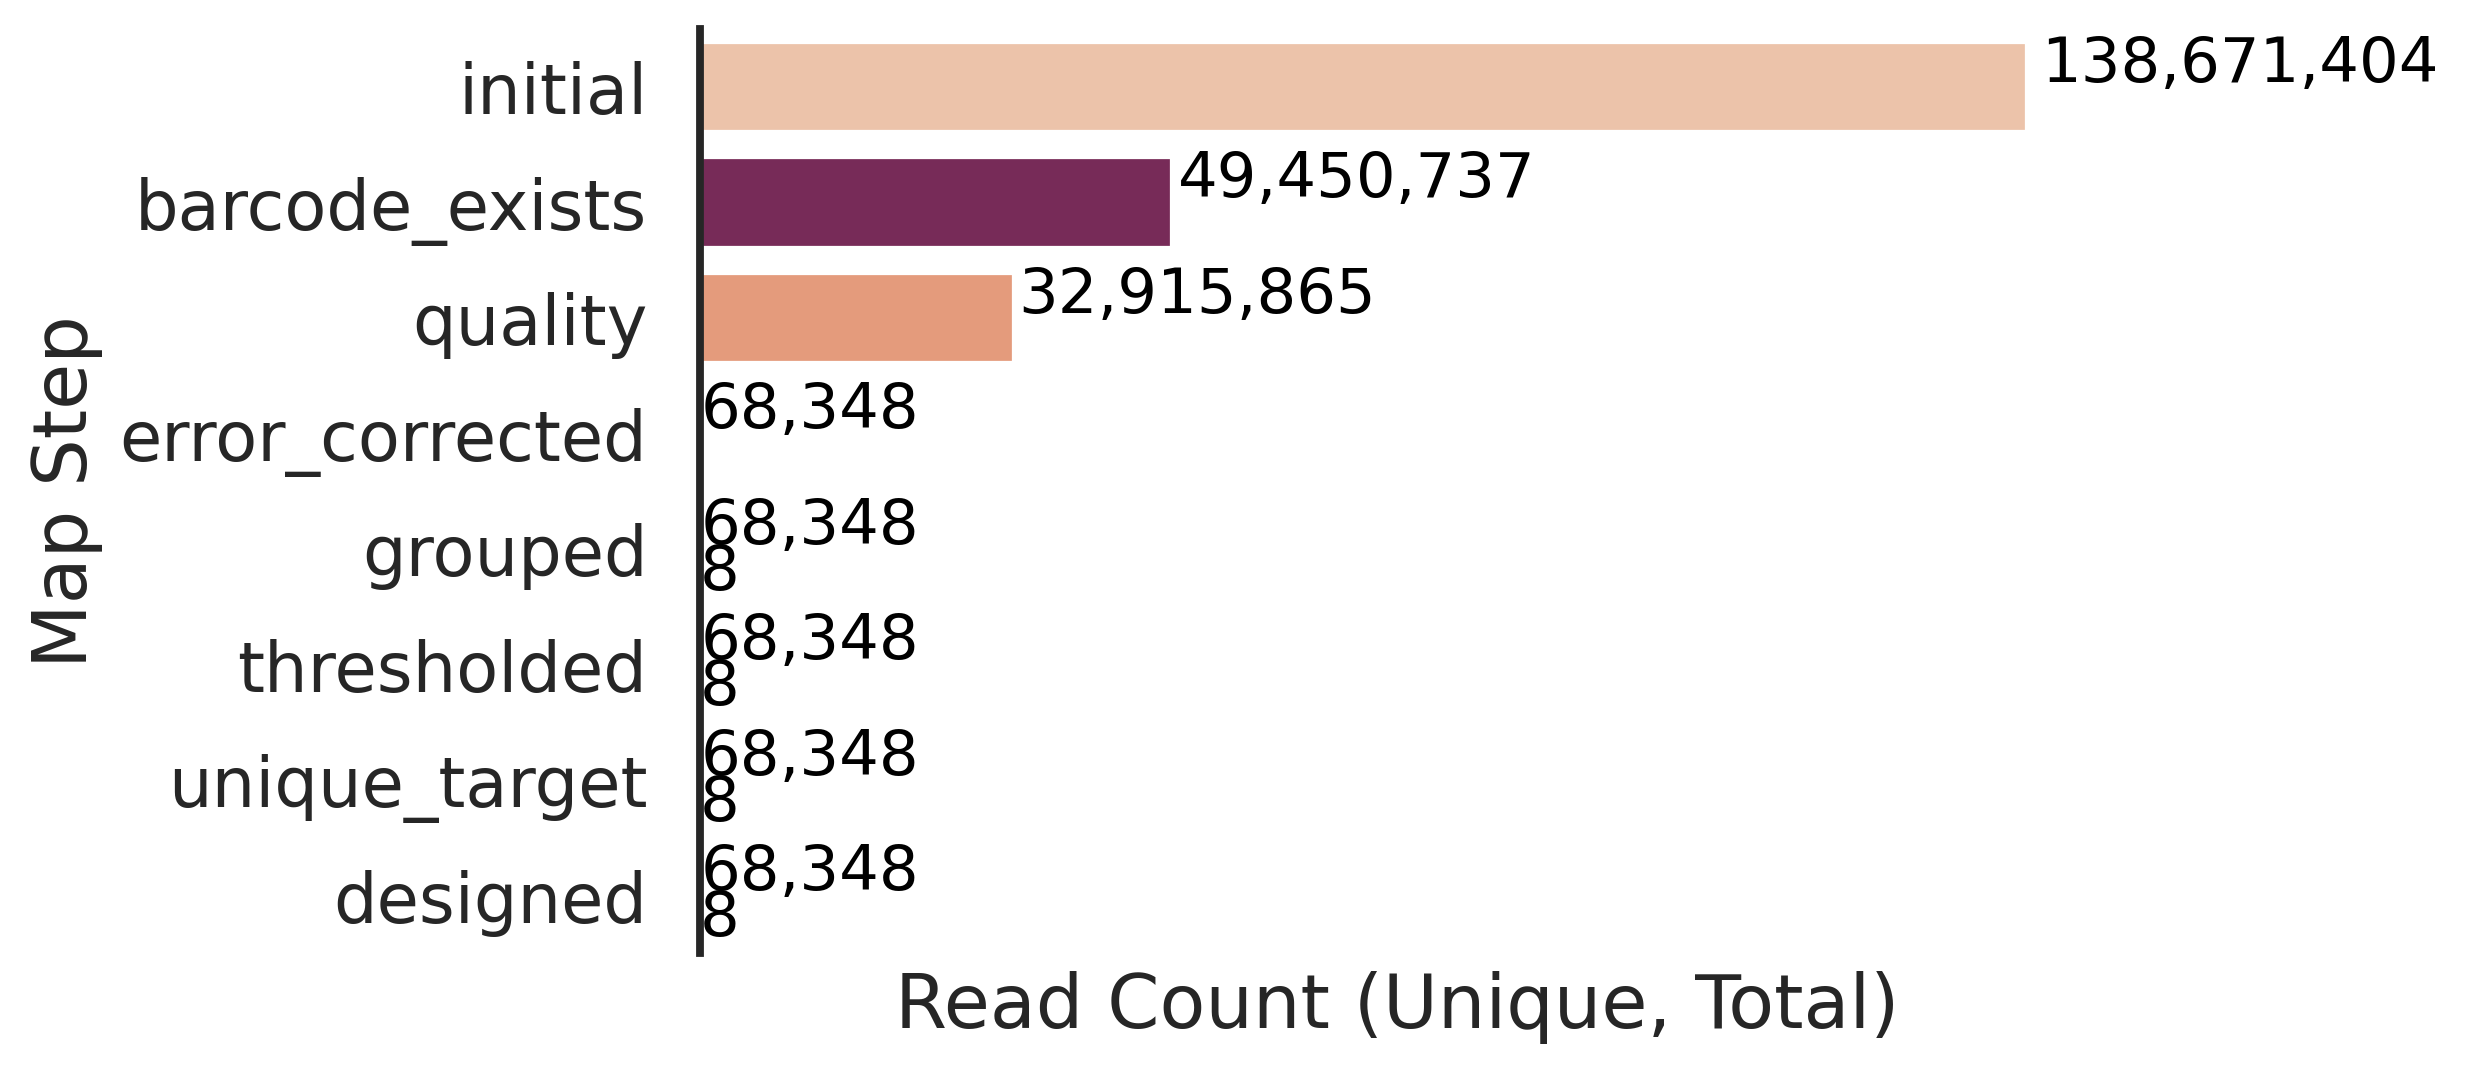

In [9]:
refiner.plot_loss(text_offset = -0.2)